## Download Dataset

In [ ]:
import kagglehub

# Download
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-mri-images-for-brain-tumor-detection


## Split into Train/Test Sets

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define source and target paths
yes_dir = os.path.join(path, "yes")
no_dir = os.path.join(path, "no")

train_dir = "/content/brain_mri/train"
test_dir = "/content/brain_mri/test"

for label in ["yes", "no"]:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

# Split and copy files
for label_dir in [yes_dir, no_dir]:
    label = os.path.basename(label_dir)
    files = os.listdir(label_dir)
    train_files, test_files = train_test_split(files, test_size=0.33, random_state=42)

    for f in train_files:
        shutil.copy(os.path.join(label_dir, f), os.path.join(train_dir, label, f))
    for f in test_files:
        shutil.copy(os.path.join(label_dir, f), os.path.join(test_dir, label, f))


## Preprocessing Code: Resize + Grayscale + Median Filter

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt

# Set paths
input_dir = "/content/brain_mri"
output_dir = "/content/brain_mri_preprocessed"
image_size = (128, 128)

# Create output folders
for split in ['train', 'test']:
    for label in ['yes', 'no']:
        os.makedirs(os.path.join(output_dir, split, label), exist_ok=True)

# Preprocessing function
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.resize(img, image_size)            # Resize
    img = cv2.medianBlur(img, 3)                 # Apply median filter
    return img

# Process all images
for split in ['train', 'test']:
    for label in ['yes', 'no']:
        input_path = os.path.join(input_dir, split, label)
        output_path = os.path.join(output_dir, split, label)
        for img_file in tqdm(glob(os.path.join(input_path, "*.jpg"))):
            img = preprocess_image(img_file)
            filename = os.path.basename(img_file)
            cv2.imwrite(os.path.join(output_path, filename), img)

print("✅ Preprocessing complete. Images saved to:", output_dir)


100%|██████████| 25/25 [00:00<00:00, 778.67it/s]

✅ Preprocessing complete. Images saved to: /content/brain_mri_preprocessed


## Visualize a Sample

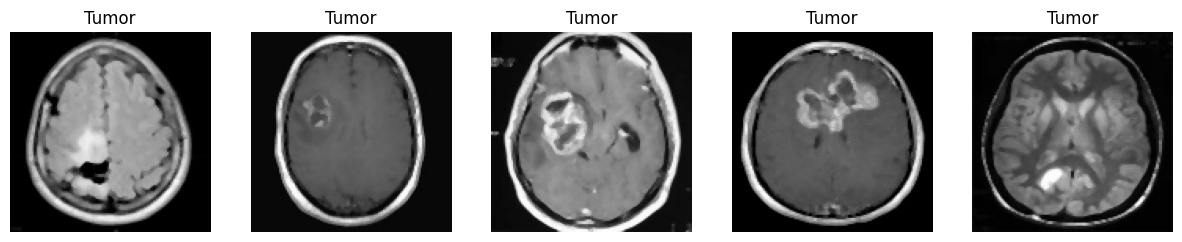

In [ ]:
# Show a few preprocessed images
sample_imgs = glob(os.path.join(output_dir, 'train', 'yes', '*.jpg'))[:5]

plt.figure(figsize=(15, 3))
for i, img_path in enumerate(sample_imgs):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title("Tumor")
    plt.axis('off')
plt.show()


## CNN Classification Code (Keras)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Set paths
train_path = "/content/brain_mri_preprocessed/train"
test_path = "/content/brain_mri_preprocessed/test"

# Image generators
train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(train_path, target_size=(128, 128), color_mode='grayscale', batch_size=32, class_mode='binary')
test_data = test_gen.flow_from_directory(test_path, target_size=(128, 128), color_mode='grayscale', batch_size=32, class_mode='binary')

# CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(train_data, validation_data=test_data, epochs=10)

# Evaluate
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Found 116 images belonging to 2 classes.
Found 55 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.5520 - loss: 0.7038

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 889ms/step - accuracy: 0.5589 - loss: 0.6998 - val_accuracy: 0.7818 - val_loss: 0.5354
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 860ms/step - accuracy: 0.7274 - loss: 0.5666 - val_accuracy: 0.7273 - val_loss: 0.5220
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 784ms/step - accuracy: 0.7457 - loss: 0.4852 - val_accuracy: 0.8182 - val_loss: 0.4387
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 783ms/step - accuracy: 0.7680 - loss: 0.4999 - val_accuracy: 0.7636 - val_loss: 0.4270
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 751ms/step - accuracy: 0.7963 - loss: 0.4378 - val_accuracy: 0.7636 - val_loss: 0.4043
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8202 - loss: 0.3718 - val_accuracy: 0.8000 - val_loss: 0.4418
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 989ms/step - accuracy: 0.8542 - loss: 0.3063 - val_accuracy: 0.8000 - val_loss: 0.3901
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 746ms/step - accuracy: 0.9106 - loss: 0.2573 - val_accuracy: 0.8000 - val_loss: 0.3757
Epoch 

## Plot Accuracy & Loss

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()





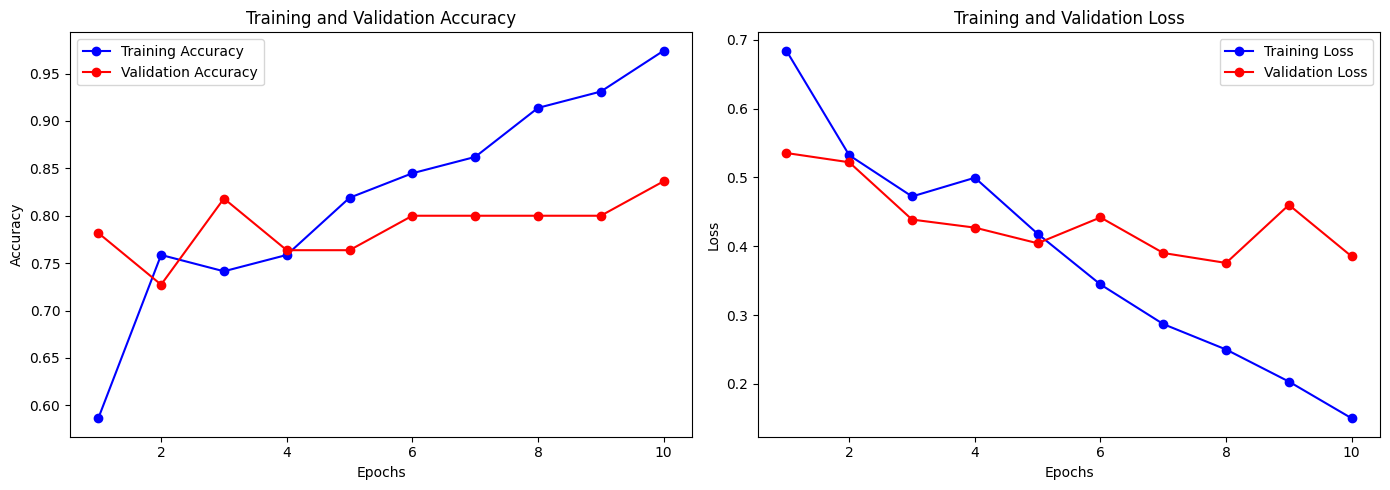

In [ ]:
plot_training_history(history)


## Saving the model and evaluating it further (e.g., confusion matrix, classification report)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8284 - loss: 0.4053
Test Accuracy: 83.64%
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step

Classification Report:
              precision    recall  f1-score   support

          no       0.43      0.48      0.45        25
         yes       0.52      0.47      0.49        30

    accuracy                           0.47        55
   macro avg       0.47      0.47      0.47        55
weighted avg       0.48      0.47      0.47        55



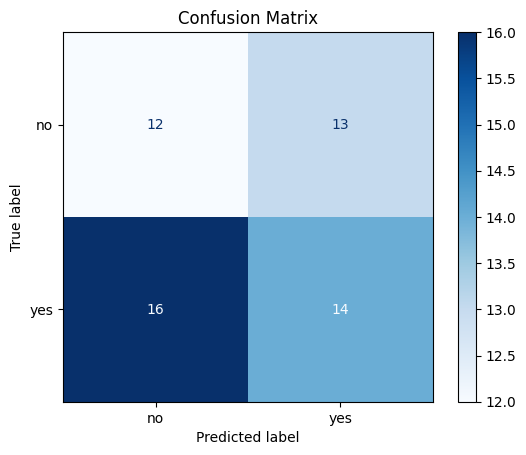

✅ Model saved as 'brain_tumor_classifier.h5'


In [ ]:
# Evaluate and visualize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Evaluate
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict
y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()
y_true = test_data.classes

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_data.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Save model
model.save("brain_tumor_classifier.h5")
print("✅ Model saved as 'brain_tumor_classifier.h5'")


## Load the Saved Model

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("brain_tumor_classifier.h5")
print("✅ Model loaded successfully.")


✅ Model loaded successfully.


## Predict on New Images

In [ ]:
import cv2
import numpy as np

def predict_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    img = np.expand_dims(img, axis=(0, -1))  # Shape: (1, 128, 128, 1)

    prediction = model.predict(img)[0][0]
    label = "Tumor" if prediction > 0.5 else "No Tumor"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    print(f"Prediction: {label} ({confidence * 100:.2f}%)")




## Deploy

In [ ]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.5 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from PIL import Image

# Load model
model = load_model("brain_tumor_classifier.h5")

# Title
st.title("🧠 Brain Tumor MRI Classifier")

# Upload image
uploaded_file = st.file_uploader("Upload an MRI image", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("L")  # Convert to grayscale
    image_resized = image.resize((128, 128))
    img_array = np.array(image_resized) / 255.0
    img_input = np.expand_dims(img_array, axis=(0, -1))  # Shape: (1, 128, 128, 1)

    # Prediction
    prediction = model.predict(img_input)[0][0]
    label = "Tumor" if prediction > 0.5 else "No Tumor"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    # Show image and result
    st.image(image, caption="Uploaded MRI", use_column_width=True)
    st.markdown(f"### 🧾 Prediction: **{label}**")
    st.markdown(f"### 🔍 Confidence: **{confidence * 100:.2f}%**")


2025-07-10 07:01:59.891 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 07:02:01.153 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-10 07:02:01.160 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 07:02:01.164 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 07:02:01.177 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 07:02:01.179 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 07:02:01.186 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-10 07:02:01.188 Thread 'MainThread': mi

In [ ]:
!pip install streamlit pyngrok --quiet


In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token("2zfuAo4x5UbVgANj7ySOlgAbEP0_6P1v9MwkAC7KhMYKJsgPL")


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from PIL import Image

model = load_model("brain_tumor_classifier.h5")

st.title("🧠 Brain Tumor MRI Classifier")

uploaded_file = st.file_uploader("Upload an MRI image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("L")
    st.image(image, caption="Uploaded MRI", use_column_width=True)

    image_resized = image.resize((128, 128))
    img_array = np.array(image_resized) / 255.0
    img_input = np.expand_dims(img_array, axis=(0, -1))

    prediction = model.predict(img_input)[0][0]
    label = "Tumor" if prediction > 0.5 else "No Tumor"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    st.markdown(f"### 🧾 Prediction: **{label}**")
    st.markdown(f"### 🔍 Confidence: **{confidence * 100:.2f}%**")


Writing app.py


In [ ]:
import threading
import time
import os

def run():
    os.system("streamlit run app.py")

thread = threading.Thread(target=run)
thread.start()

time.sleep(5)

public_url = ngrok.connect(8501)
print(f"🌐 Your app is live at: {public_url}")


🌐 Your app is live at: NgrokTunnel: "https://219959dbfe4e.ngrok-free.app" -> "http://localhost:8501"
